In [12]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*

#Open ROOT file with uproot--------------------------------------------------------------------------------------------
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 

#Get trees-------------------------------------------------------------------------------------------------------------
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]


nmin1=0
nmax1=5000

Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

dr_min=0.1
dr_max=0.6
Zmumu_iso=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin1, nmax1])
Zmumu_ratio=ak.flatten(Zmumu_iso)/ak.flatten(Zmumu_pt)

Zmumu_iso=ak.flatten(Zmumu_iso)
Zmumu_iso=Zmumu_iso[~np.isnan(Zmumu_iso)]
l1=len(Zmumu_iso)
l3=len(Zmumu_ratio)


100%|██████████| 5000/5000 [00:06<00:00, 740.71it/s]


In [13]:
datasets=1000
e_cut= 14000
ZeroBias_pt_total=[]
ZeroBias_eta_total=[]
ZeroBias_phi_total=[]
iso_total=[]
ratio_total=[]
total_events=0
# Define  directory
base_path = "/home/ruben/Escritorio/BachelorThesisRuben/Data/NewData/"
# List directories 0, 1, 2, ...
folders = [str(f) for f in range(datasets)]
# Loop through the folders
i=0
for folder in tqdm(folders, desc="Loading data...", leave=False):
    file_path = os.path.join(base_path, folder, 'l1calo_hist.root')
    # Check if the file exists before attempting to open it
    if os.path.exists(file_path):
        # Open the ROOT file
        file = uproot.open(file_path)
        #Since datasets 998 and 999 are different, this "if" ensures they are loaded correctly
        if i == 999:
            Tree="MuonTree_ZeroBias;1"
            MuonTree_ZeroBias=file[Tree]
        else:
            Tree="MuonTree;1"
            MuonTree_ZeroBias=file[Tree]
        
        ###############################################################################################################################3
        #Select ZeroBias
        total_events=total_events+len(MuonTree_ZeroBias["muon_pt"].array())
        ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array(), e_cut)
        ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array(), e_cut)
        ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array(), e_cut)

        Zbl1_pt = MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
        Zbl1_eta = MuonTree_ZeroBias["LVL1Muon_eta"].array()
        Zbl1_phi = MuonTree_ZeroBias["LVL1Muon_phi"].array()

        #Select LVL1 ZeroBias
        mask = Zbl1_pt >= e_cut

        Zbl1_pt=Zbl1_pt[mask]
        Zbl1_eta=Zbl1_eta[mask]
        Zbl1_phi=Zbl1_phi[mask]
        #Compute matchings
        mask = offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi)
        #Apply them
        ZeroBias_pt=ZeroBias_pt[mask]
        ZeroBias_eta=ZeroBias_eta[mask]
        ZeroBias_phi=ZeroBias_phi[mask]
        #Compute isolations 
        iso=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [0, len(ZeroBias_pt)])
        ratio=ak.flatten(iso)/ak.flatten(ZeroBias_pt)
        #Concatenate with other data
        ZeroBias_pt_total=ak.concatenate([ZeroBias_pt_total,ZeroBias_pt[ak.num(ZeroBias_pt) > 0]])
        ZeroBias_eta_total=ak.concatenate([ZeroBias_eta_total,ZeroBias_eta[ak.num(ZeroBias_pt) > 0]])
        ZeroBias_phi_total=ak.concatenate([ZeroBias_phi_total,ZeroBias_phi[ak.num(ZeroBias_pt) > 0]])

        iso_total=ak.concatenate([iso_total, iso])
        ratio_total=ak.concatenate([ratio_total, ratio])

    i=i+1
#Remove nan and empty
iso_total=iso_total[~np.isnan(iso_total)]
ZeroBias_iso=iso_total[ak.num(iso_total) > 0]
ZeroBias_ratio=ratio_total[~np.isnan(ratio_total)]
print("Number of events scanned", total_events)
print("Post-selected ZeroBias length", len(ZeroBias_pt_total))
print("Total Isolation length", len(ZeroBias_iso))

Number of events scanned 1330177
Post-selected ZeroBias length 165
Total Isolation length 86


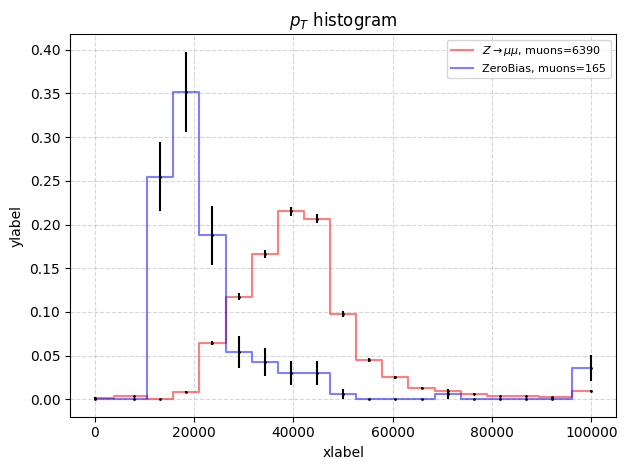

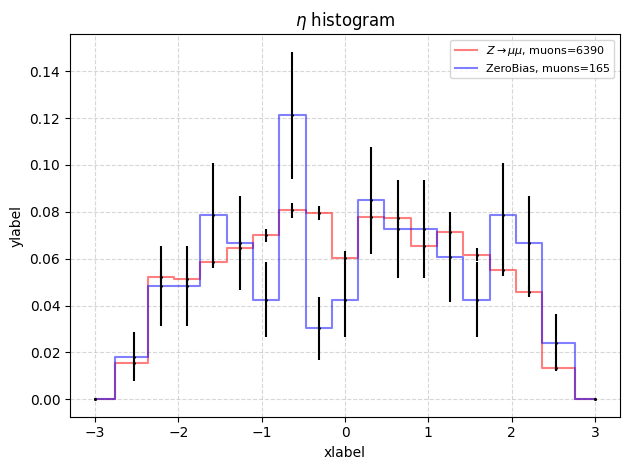

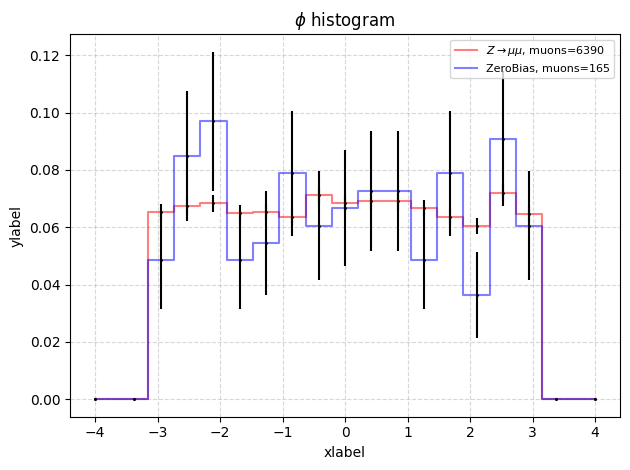

In [14]:
l2=len(ak.flatten(ZeroBias_pt_total[ak.num(ZeroBias_pt_total) > 0]))
coolplot([Zmumu_pt, ZeroBias_pt_total], np.linspace(0,10*10**4,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$p_T$ histogram")
coolplot([Zmumu_eta, ZeroBias_eta_total], np.linspace(-3,3,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\eta$ histogram")
coolplot([Zmumu_phi, ZeroBias_phi_total], np.linspace(-4,4,20), labels=[rf"$Z\to\mu\mu$, muons={l1}", f"ZeroBias, muons={l2}"], title=r"$\phi$ histogram")

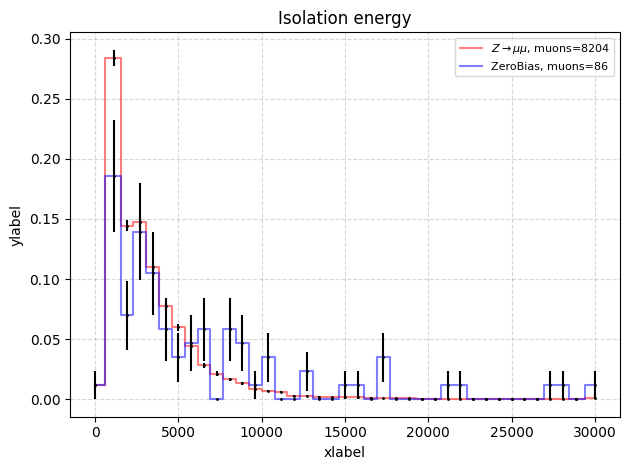

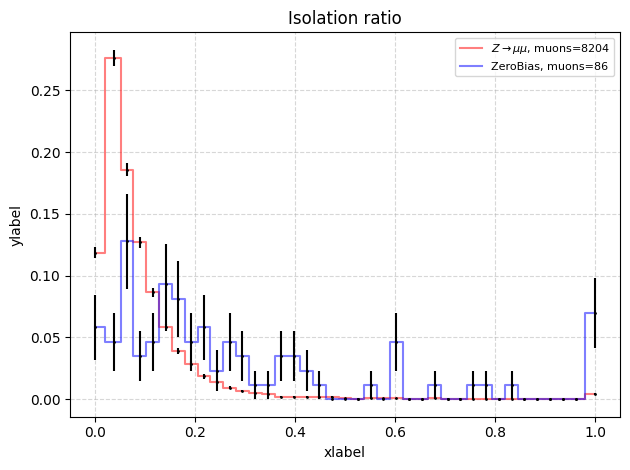

In [15]:
l4=len(ZeroBias_iso)
coolplot([Zmumu_iso, ZeroBias_iso], bins=np.linspace(0,30000,40), labels=[rf"$Z\to\mu\mu$, muons={l3}", f"ZeroBias, muons={l4}"], title="Isolation energy")
coolplot([Zmumu_ratio, ZeroBias_ratio], bins=np.linspace(0,1,40), labels=[rf"$Z\to\mu\mu$, muons={l3}", f"ZeroBias, muons={l4}"], title="Isolation ratio")

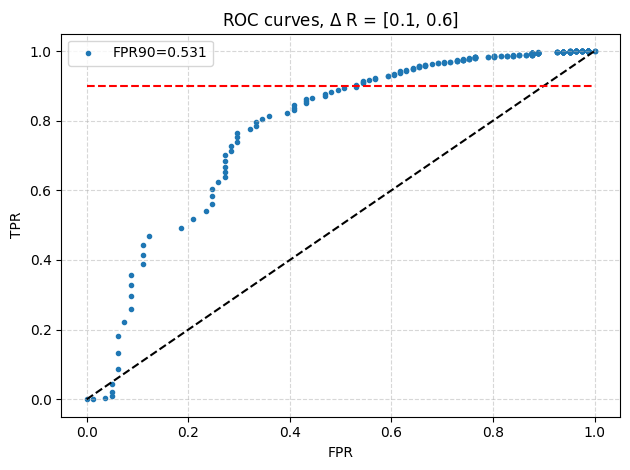

In [16]:
bins=np.linspace(0,1,300)
Zmumu_counts, _ = np.histogram(Zmumu_ratio, bins)
ZeroBias_counts, _ = np.histogram(ZeroBias_ratio, bins)
#Compute the cumulative sum of the counts (like integrating the histogram to the left)
Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
# Normalize to total events
TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)

FPR90=min(FPR[TPR >= 0.9])
plt.scatter(FPR, TPR, marker='.', label=fr'FPR90={np.round(FPR90,3)}')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.plot([0,1],[0.9,0.9],color='r', linestyle='--')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title(rf"ROC curves, $\Delta$ R = [{dr_min}, {dr_max}]")
plt.tight_layout()